# Nearest-neighbor graph mappings

In [2]:
import os

import xarray as xr
import numpy as np

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from sklearn.neighbors import NearestNeighbors

In [5]:
import dask
from dask.distributed import Client, LocalCluster

In [6]:
import torch
from torch_geometric.data import HeteroData 

/perm/nesl/conda/envs/dev-pyg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import h3
import networkx as nx

In [8]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

/perm/nesl/conda/envs/dev-pyg/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33637 instead
  warnings.warn(


In [9]:
h3_resolutions = (0,1,2) # resolution of h3 grids

In [10]:
NUM_ERA_NEIGHBORS = 3
NUM_H3_NEIGHBORS = 7

## ERA5 -> H3

In [11]:
with client:
    era = xr.open_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/pl_2004.nc", chunks={"time": 5})
era

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, level: 13, time: 1464)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    w          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-24 22:24:48 GMT by grib_to_netcdf-2.23.0: grib_to_n...

In [12]:
era = era.assign_coords({"longitude": (((era.longitude + 180) % 360) - 180)})
era = era.sortby("longitude").sortby("latitude")
era

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, level: 13, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    w          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(5, 13, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-24 22:24:48 GMT by grib_to_netcdf-2.23.0: grib_to_n...

In [13]:
era.longitude.min(), era.longitude.max()

(<xarray.DataArray 'longitude' ()>
 array(-180.),
 <xarray.DataArray 'longitude' ()>
 array(179.))

In [14]:
era.latitude.min(), era.latitude.max()

(<xarray.DataArray 'latitude' ()>
 array(-90.),
 <xarray.DataArray 'latitude' ()>
 array(90.))

In [15]:
elats, elons = np.meshgrid(era.latitude.values, era.longitude.values)
ecoords = np.array([elats, elons]).T.reshape((-1, 2))
ecoords.shape

(65160, 2)

In [16]:
elats = np.array(era["latitude"])
elons = np.array(era["longitude"])
ecoords_v2 = np.stack(np.meshgrid(elats, elons, indexing="ij"), axis=-1).reshape((-1,2))
ecoords_v2.shape

(65160, 2)

In [17]:
np.max(ecoords - ecoords_v2)

0.0

In [18]:
# convert to rad
ecoords_sp = np.deg2rad(ecoords)

eneigh = NearestNeighbors(
    n_neighbors=NUM_ERA_NEIGHBORS,
    metric="haversine",
    n_jobs=4
)
eneigh.fit(ecoords_sp)

NearestNeighbors(metric='haversine', n_jobs=4, n_neighbors=3)

In [19]:
eadjmat = eneigh.kneighbors_graph(ecoords_sp, NUM_ERA_NEIGHBORS, mode="distance").tocoo()

In [20]:
eadjmat

<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 195480 stored elements in COOrdinate format>

In [79]:
from gnn_era5.utils.graph_gen import multi_mesh

G = multi_mesh(h3_resolutions, depth=1)

print(G.number_of_nodes(), G.number_of_edges())

print(G.nodes['8091fffffffffff'])
print(G.edges[('8053fffffffffff', '8063fffffffffff')])


6846 114972
{'latlon': (-10.447345187511036, -121.8422941604274)}
{'weight': 0.2874943116708853}


In [22]:
#base_h3_grid = sorted(list(h3.uncompact(h3.get_res0_indexes(), resolution)))
#base_h3_map = {h_i: i for i, h_i in enumerate(base_h3_grid)}
#h3_grid = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in lat_lons]


In [23]:
#h3_grid = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in ecoords]
h3_grid = [node for node in G.nodes] #sorted(set(h3_grid))
hcoords = np.array([h3.h3_to_geo(val) for val in h3_grid])

In [24]:
hcoords[:10, :]

array([[   7.4605296 ,  -95.54685826],
       [ -60.18522013, -134.69347247],
       [ -24.48652699,   71.7753657 ],
       [ -33.90875095,   32.41999745],
       [  10.44734519,   58.15770584],
       [ -48.75834972, -161.69695552],
       [   7.71667519,  117.1940607 ],
       [  15.07156124,  -34.68841204],
       [  16.7028683 ,  -13.3748451 ],
       [ -52.67575112,  168.39837439]])

In [25]:
ecoords[:10, :]

array([[ -90., -180.],
       [ -90., -179.],
       [ -90., -178.],
       [ -90., -177.],
       [ -90., -176.],
       [ -90., -175.],
       [ -90., -174.],
       [ -90., -173.],
       [ -90., -172.],
       [ -90., -171.]], dtype=float32)

In [26]:
hcoords_sp = np.deg2rad(hcoords)
hcoords_sp.min(), hcoords_sp.max()

(-3.1411522715671913, 3.140526772388204)

In [27]:
hcoords_sp[:5, :]

array([[ 0.13021081, -1.66760727],
       [-1.05043025, -2.35084458],
       [-0.42737052,  1.25271645],
       [-0.59181935,  0.5658357 ],
       [ 0.18234057,  1.01504345]])

In [28]:
np.cos(hcoords_sp[:5, :]), np.sin(hcoords_sp[:5, :])

(array([[ 0.99153454, -0.09665979],
        [ 0.49719779, -0.70331372],
        [ 0.91005876,  0.31274333],
        [ 0.82992709,  0.84414086],
        [ 0.98342197,  0.52758302]]),
 array([[ 0.12984317, -0.99531748],
        [-0.86763723, -0.7108796 ],
        [-0.41447926,  0.94983768],
        [-0.55787187,  0.53612145],
        [ 0.18133184,  0.84950348]]))

In [29]:
np.cos(hcoords_sp[-5:, :]), np.sin(hcoords_sp[-5:, :])

(array([[ 0.9990166 , -0.7856433 ],
        [ 0.99902468, -0.0931898 ],
        [ 0.55568488, -0.99971399],
        [ 0.84576041, -0.36314014],
        [ 0.96808606, -0.79835389]]),
 array([[ 0.04433775, -0.61867973],
        [ 0.04415538, -0.99564836],
        [-0.831393  ,  0.02391543],
        [ 0.53356287, -0.93173453],
        [ 0.250618  ,  0.60218856]]))

In [30]:
hneigh = NearestNeighbors(
    n_neighbors=NUM_H3_NEIGHBORS,
    metric="haversine",
    n_jobs=4
)
hneigh.fit(hcoords_sp)

hadjmat_old = hneigh.kneighbors_graph(hcoords_sp, NUM_H3_NEIGHBORS, mode="distance").tocoo()

hadjmat = nx.to_scipy_sparse_array(G, format='coo')

In [31]:
hadjmat_old

<6846x6846 sparse matrix of type '<class 'numpy.float64'>'
	with 47922 stored elements in COOrdinate format>

In [32]:
hadjmat

<6846x6846 sparse array of type '<class 'numpy.float64'>'
	with 236790 stored elements in COOrdinate format>

In [33]:
print(hadjmat_old.data.shape, hadjmat_old.col.shape)
print(hadjmat.data.shape, hadjmat.col.shape)

(47922,) (47922,)
(236790,) (236790,)


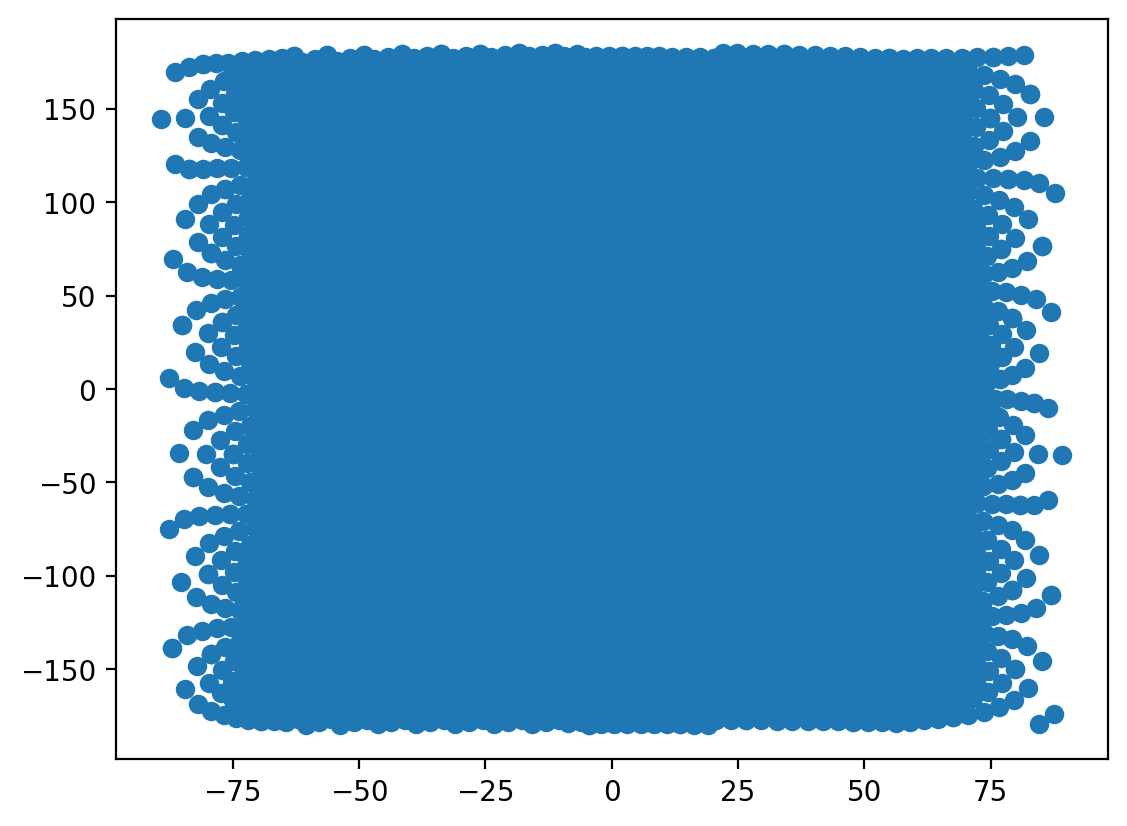

In [34]:
plt.scatter(hcoords[:,0],hcoords[:,1])

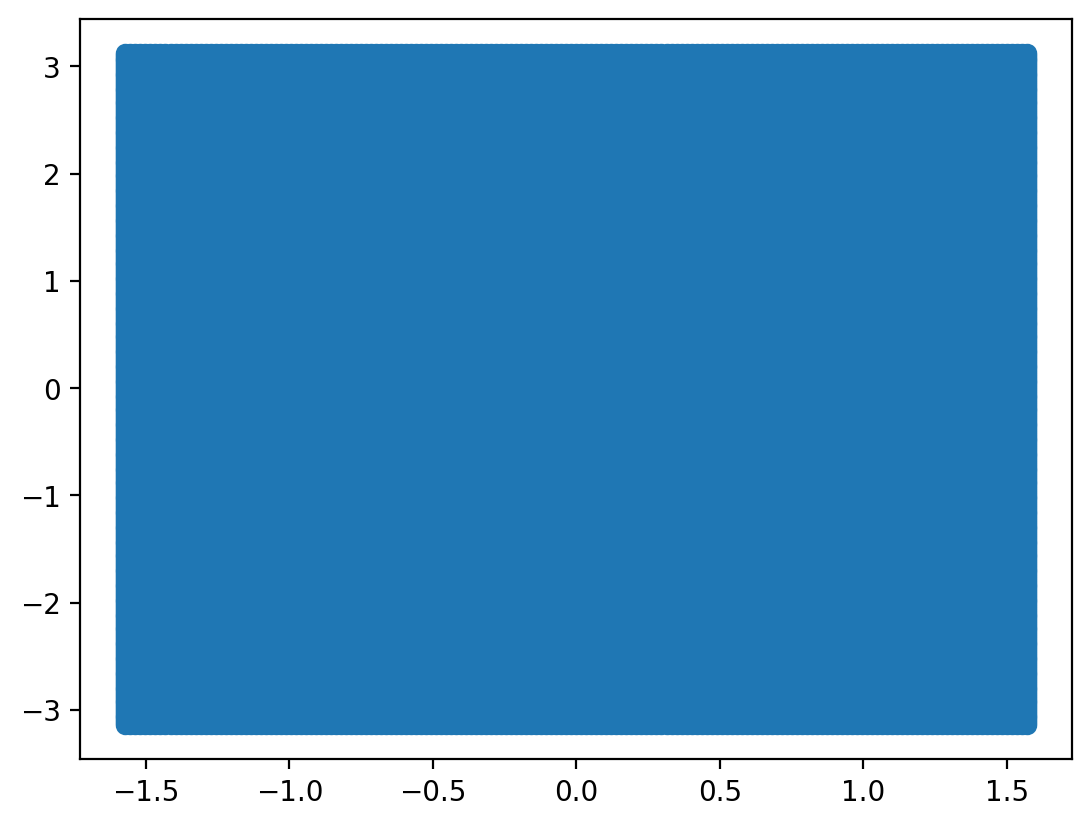

In [35]:
plt.scatter(ecoords_sp[:,0],ecoords_sp[:,1])

In [36]:
eadjmat, hadjmat

(<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
 	with 195480 stored elements in COOrdinate format>,
 <6846x6846 sparse array of type '<class 'numpy.float64'>'
 	with 236790 stored elements in COOrdinate format>)

In [37]:
from sklearn.preprocessing import normalize
eadjmat_norm = normalize(eadjmat, norm="l1", axis=1)
eadjmat_norm.data = 1.0 - eadjmat_norm.data
eadjmat_norm

<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 195480 stored elements in Compressed Sparse Row format>

In [38]:
eadjmat_norm[0, :].data

array([1.       , 0.4999975, 0.5000025])

In [39]:
hadjmat_norm_old = normalize(hadjmat_old, norm="l1", axis=1)
hadjmat_norm_old.data = 1.0 - hadjmat_norm_old.data
hadjmat_norm_old

<6846x6846 sparse matrix of type '<class 'numpy.float64'>'
	with 47922 stored elements in Compressed Sparse Row format>

In [40]:
hadjmat_norm = normalize(hadjmat, norm="l1", axis=1)
hadjmat_norm.data = 1.0 - hadjmat_norm.data
hadjmat_norm

<6846x6846 sparse array of type '<class 'numpy.float64'>'
	with 223098 stored elements in Compressed Sparse Row format>

In [41]:
print(hadjmat_old.col)
print(hadjmat.col)

[   0  413 3842 ...  892 2435 5068]
[  46   66    0 ... 6843 6844 6845]


In [42]:
#print(hadjmat_norm_old[0, :].data)
#print(hadjmat_norm[0, :].data)

In [43]:
# includes "self"
NUM_H3_TO_ERA_NEIGHBORS = 4
NUM_ERA_TO_H3_NEIGHBORS = 12

In [44]:
# compute mappings
# H3 -> ERA aka the "decoder"
h3_to_era_adjmat = hneigh.kneighbors_graph(
    ecoords_sp,
    n_neighbors=NUM_H3_TO_ERA_NEIGHBORS,
    mode="distance",
).tocoo()

# ERA -> H3 aka the "encoder"
era_to_h3_adjmat = eneigh.kneighbors_graph(
    hcoords_sp,
    n_neighbors=NUM_ERA_TO_H3_NEIGHBORS,
    mode="distance",
).tocoo()

In [45]:
h3_to_era_adjmat

<65160x6846 sparse matrix of type '<class 'numpy.float64'>'
	with 260640 stored elements in COOrdinate format>

In [46]:
hadjmat.max(),hadjmat.min()

(0.5553121701983778, 0.0)

In [47]:
h3_to_era_adjmat.max(),h3_to_era_adjmat.min()

(0.061952872428506264, 0.0)

In [48]:
np.unravel_index(h3_to_era_adjmat.argmax(),h3_to_era_adjmat.shape)

(14826, 1111)

In [49]:
h3_to_era_adjmat.data[49327-24:49327+5]

array([0.04137368, 0.04834984, 0.03426576, 0.02426722, 0.0246749 ,
       0.03512824, 0.04964205, 0.04322399, 0.02606926, 0.00975775,
       0.01073019, 0.02719136, 0.04436123, 0.04450737, 0.02818107,
       0.01451725, 0.01518686, 0.0292205 , 0.04561082, 0.0389595 ,
       0.03058609, 0.03090893, 0.03971644, 0.04763915, 0.04784664,
       0.04737659, 0.04707768, 0.03667903, 0.03023145])

In [50]:
h3_to_era_adjmat.col[49327-12:49327+5]

array([1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340,
       1340, 1340, 1341, 1341, 1341, 1341], dtype=int32)

In [51]:
hcoords_sp[h3_to_era_adjmat.col[49327-12:49327+5],:]

array([[ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.09268009,  1.45677455],
       [ 0.57042901, -2.99356449],
       [ 0.57042901, -2.99356449],
       [ 0.57042901, -2.99356449],
       [ 0.57042901, -2.99356449]])

In [52]:
ecoords_sp[h3_to_era_adjmat.row[49327-12:49327+5],:]

array([[ 0.08726646,  1.5009831 ],
       [ 0.10471976,  1.4137167 ],
       [ 0.10471976,  1.43117   ],
       [ 0.10471976,  1.4486233 ],
       [ 0.10471976,  1.4660766 ],
       [ 0.10471976,  1.4835298 ],
       [ 0.10471976,  1.5009831 ],
       [ 0.12217305,  1.43117   ],
       [ 0.12217305,  1.4486233 ],
       [ 0.12217305,  1.4660766 ],
       [ 0.12217305,  1.4835298 ],
       [ 0.13962634,  1.4486233 ],
       [ 0.13962634,  1.4660766 ],
       [ 0.5235988 , -3.0019662 ],
       [ 0.54105204, -3.0368729 ],
       [ 0.54105204, -3.0194197 ],
       [ 0.54105204, -3.0019662 ]], dtype=float32)

In [53]:
h3_to_era_adjmat.row[49327-12:49327+5]

array([34466, 34821, 34822, 34823, 34824, 34825, 34826, 35182, 35183,
       35184, 35185, 35543, 35544, 43208, 43566, 43567, 43568],
      dtype=int32)

In [54]:
era_to_h3_adjmat.max(),era_to_h3_adjmat.min()

(0.03648317456381662, 0.0)

In [55]:
h3_to_era_adjmat_norm = normalize(h3_to_era_adjmat, norm="l1", axis=1)
h3_to_era_adjmat_norm.data = 1.0 - h3_to_era_adjmat_norm.data
h3_to_era_adjmat_norm

<65160x6846 sparse matrix of type '<class 'numpy.float64'>'
	with 260640 stored elements in Compressed Sparse Row format>

In [56]:
era_to_h3_adjmat

<6846x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 82152 stored elements in COOrdinate format>

In [57]:
era_to_h3_adjmat.data[:10]

array([0.00445776, 0.00437873, 0.00431455, 0.00426589, 0.00423331,
       0.00421719, 0.00421773, 0.00423492, 0.00426855, 0.00431823])

In [58]:
era_to_h3_adjmat_norm = normalize(era_to_h3_adjmat, norm="l1", axis=1)
era_to_h3_adjmat_norm.data = 1.0 - era_to_h3_adjmat_norm.data
era_to_h3_adjmat_norm

<6846x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 82152 stored elements in Compressed Sparse Row format>

In [59]:
tmp = era_to_h3_adjmat_norm[:10].toarray()
nz_idx = np.where(tmp != 0.)
tmp[tmp != 0].shape

(120,)

In [60]:
nz_idx

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([34644, 34645, 35003, 35004, 35005, 35006, 35363, 35364, 35365,
        35366, 35724, 35725, 10484, 10485, 10486, 10487, 10843, 10844,
        10845, 10846, 10847, 10848, 11205, 11206, 23291, 23292, 23650,
        23651, 23652, 23653, 24010, 24011, 24012, 24013, 24371, 24372,
        20011, 20012, 20013, 20014, 20371, 20372, 20373, 20374, 20731,
        20732, 20733, 20734, 35877, 35878, 35879, 36237, 36238, 36239,
        36240, 36597, 36598, 36599, 36958, 36959, 14417, 14418, 14419,
        14776, 14777, 14778, 14779, 14780, 15137, 15138, 15139, 15140,
        34857, 34858, 

In [61]:
tmp[9, [1800, 1801,1802, 1803, 1804, 1805, 1806, 2155, 2156, 2157, 2158, 2159]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [62]:
tmp = hadjmat_norm[:10, :].toarray()
nz_idx = np.where(tmp != 0.)
nz_idx

(array([0, 0, 0, ..., 9, 9, 9]),
 array([   0,   12,   46, ..., 6819, 6823, 6843]))

In [63]:
tmp[9, [7,  8,  9 , 10, 11, 12, 13]]

array([0., 0., 1., 0., 0., 0., 0.])

In [64]:
graphs = HeteroData(
    {
        # we should swap rows and cols here. It does not matter too much since the
        # adjacency matrix is symmetric but better be consistent
        ("h", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([hadjmat.col, hadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(hadjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        # and again here
        ("era", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([eadjmat.col, eadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(eadjmat.data, axis=-1).astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
        },

        # be careful, we need to swap rows and cols here
        ("h", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([h3_to_era_adjmat.col, h3_to_era_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(h3_to_era_adjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        ("era", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(era_to_h3_adjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },
    }
)

In [65]:
graphs_normed = HeteroData(
    {
        # we should swap rows and cols here. It does not matter too much since the
        # adjacency matrix is symmetric but better be consistent
        ("h", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([hadjmat.col, hadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(hadjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        # and again here
        ("era", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([eadjmat.col, eadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(eadjmat_norm.data, axis=-1).astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
        },

        # be careful, we need to swap rows and cols here
        ("h", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([h3_to_era_adjmat.col, h3_to_era_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(h3_to_era_adjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        ("era", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(era_to_h3_adjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },
    }
)

# Add directionality attribute

In [66]:
#
hhedge_dirs = []
for n in range(graphs_normed[("h", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "h")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "h")]['hcoords_rad'][j,:]
    hhedge_dirs.append(jc - ic)
hhedge_dirs = torch.from_numpy(np.stack(hhedge_dirs).astype(np.float32))
hhedge_attr = torch.concat([graphs_normed[("h", "to", "h")]['edge_attr'],hhedge_dirs],axis=-1)

In [67]:
#
ehedge_dirs = []
for n in range(graphs_normed[("era", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("era", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("era", "to", "h")]['ecoords_rad'][i,:]
    jc = graphs_normed[("era", "to", "h")]['hcoords_rad'][j,:]
    ehedge_dirs.append(jc - ic)
ehedge_dirs = torch.from_numpy(np.stack(ehedge_dirs).astype(np.float32))
ehedge_attr = torch.concat([graphs_normed[("era", "to", "h")]['edge_attr'],ehedge_dirs],axis=-1)

#
heedge_dirs = []
for n in range(graphs_normed[("h", "to", "era")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "era")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "era")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "era")]['ecoords_rad'][j,:]
    heedge_dirs.append(jc - ic)
heedge_dirs = torch.from_numpy(np.stack(heedge_dirs).astype(np.float32))
heedge_attr = torch.concat([graphs_normed[("h", "to", "era")]['edge_attr'],heedge_dirs],axis=-1)

graphs_normed[("h", "to", "era")]['edge_attr'] = heedge_attr
graphs_normed[("h", "to", "h")]['edge_attr'] = hhedge_attr
graphs_normed[("era", "to", "h")]['edge_attr'] = ehedge_attr

graphs[("h", "to", "era")]['edge_attr'] = heedge_attr
graphs[("h", "to", "h")]['edge_attr'] = hhedge_attr
graphs[("era", "to", "h")]['edge_attr'] = ehedge_attr


print(graphs_normed[("era", "to", "h")]['edge_attr'].shape)

torch.Size([82152, 3])


In [68]:
print(graphs[("h", "to", "h")]['edge_attr'].shape)

torch.Size([223098, 3])


In [69]:
print(graphs[("h", "to", "h")].keys())

KeysView({'edge_index': tensor([[   0,    0,    0,  ..., 6845, 6845, 6845],
        [   0,   12,   46,  ..., 5285, 6748, 6845]]), 'edge_attr': tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.9973, -0.3182, -0.1665],
        [ 0.9973,  0.0266,  0.3615],
        ...,
        [ 0.9861,  0.0494, -0.0188],
        [ 0.9858,  0.0098, -0.0545],
        [ 1.0000,  0.0000,  0.0000]]), 'hcoords_rad': tensor([[ 0.1302, -1.6676],
        [-1.0504, -2.3508],
        [-0.4274,  1.2527],
        ...,
        [-0.9816,  3.1177],
        [ 0.5628, -1.9424],
        [ 0.2533,  2.4954]]), 'hinfo': 'H3'})


In [70]:
output_dir = "/ec/res4/hpcperm/nesl/gnn/"
torch.save(graphs, os.path.join(output_dir, "graph_mappings_multi.pt"))

output_dir = "/ec/res4/hpcperm/nesl/gnn/"
torch.save(graphs_normed, os.path.join(output_dir, "graph_mappings_normed_edge_attrs_multi.pt"))

In [71]:
!ls -l $HPCPERM/gnn

total 110624
-rw-r----- 1 nesl rd 21486715 Feb 23 07:41 graph_mappings_multi.pt
-rw-r----- 1 nesl rd 21486715 Feb 23 07:41 graph_mappings_normed_edge_attrs_multi.pt
-rw-r----- 1 nesl rd 21688123 Feb 22 10:52 graph_mappings_normed_edge_attrs_o32.pt
-rw-r----- 1 nesl rd 19352699 Feb 22 14:47 graph_mappings_normed_edge_attrs.pt
-rw-r----- 1 nesl rd 19326587 Feb 22 10:52 graph_mappings_o32.pt
-rw-r----- 1 nesl rd 19352699 Feb 22 14:47 graph_mappings.pt
